# Word embeddings in spaCy

> ⚠️ The cells of this notebook have been executed to facilitate the use of [readthedocs.io](applied-language-technology.readthedocs.io/). If you wish to work through the notebook step-by-step, go to the *Kernel* menu and select *Restart & Clear Output*.

The previous [section](../part_iii/03_embeddings.ipynb) introduced the distributional hypothesis, which underlies modern approaches to *distributional semantics* (Boleda [2020](https://doi.org/10.1146/annurev-linguistics-011619-030303)) and the technique of word embeddings, that is, learning numerical representations for words that approximate their meaning.

We started by exploring the distributional hypothesis by quantifying word occurrences, essentially using word counts as an abstraction mechanism that enabled us to represent linguistic information numerically. 

We then moved to explore the use of a neural network as the abstraction mechanism, learning numerical representations from the data through a proxy task that involved predicting the neighbouring words. 

In this section, we proceed to word embeddings learned from massive volumes of texts, and their use in the spaCy library.

After reading this section, you should:

 - understand what word embeddings can be used for
 - know how to use word embeddings in spaCy
 - know how to visualise words in their embedding space
 - know how to use contextual word embeddings in spaCy
 - know how to add a custom component to the spaCy pipeline

## Using word embeddings in spaCy

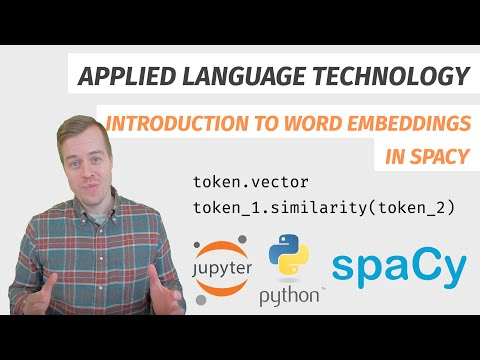

In [1]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('CHRzdvZX_mw', height=350, width=600)

spaCy provides 300-dimensional word embeddings for several languages, which have been learned from large corpora.

In other words, each word in the model's vocabulary is represented by a list of 300 floating point numbers – a vector – and these vectors are embedded into a 300-dimensional space.

To explore the use of word vectors in spaCy, let's start by loading a large language model for English, which contains word vectors for 685 000 *Token* objects.

In [2]:
# Import spacy
import spacy

# Load a large language model and assign it to the variable 'nlp_lg'
nlp_lg = spacy.load('en_core_web_lg')

Let's define an example sentence and feed it to the language model under `nlp_lg` for processing.

In [3]:
# Define example sentence
text = "The Shiba Inu is a dog that is more like a cat."

# Feed example sentence to the language model under 'nlp_lg'
doc = nlp_lg(text)

# Call the variable to examine the output
doc

The Shiba Inu is a dog that is more like a cat.

This gives us a spaCy *Doc* object.

Let's examine the word vector for the second *Token* in the *Doc* object ("Shiba"), which can be accessed through its attribute `vector`.

Instead of printing the 300 floating point numbers that constitute the vector, let's limit the output to the first thirty dimensions using `[:30]`.

In [4]:
# Retrieve the second Token in the Doc object at index 1, and 
# the first 30 dimensions of its vector representation
doc[1].vector[:30]

array([ 0.17141 ,  0.23299 ,  0.40017 , -0.58668 ,  0.051284, -0.047777,
       -0.10999 , -0.081705, -0.12037 , -1.1385  ,  0.075536, -0.32489 ,
       -0.97602 , -0.24535 , -0.15917 ,  0.95671 ,  0.44824 , -0.72333 ,
        0.038381, -0.2252  , -0.25301 ,  0.12206 ,  0.14714 , -0.50761 ,
       -0.1471  ,  0.4988  , -0.21991 , -0.51972 , -0.030737, -0.041938],
      dtype=float32)

These floating point numbers encode information about this *Token*, which the model has learned by observing the word in its context of occurrences.

Just as explained in the [previous section](../part_iii/03_embeddings.ipynb), we can use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to measure the similarity of two vectors. 

spaCy implements the measure of cosine similarity in the `similarity()` method, which is available for *Token*, *Span* and *Doc* objects.

The `similarity()` method can take any of these objects as input and calculate cosine similarity between their vector representations stored under the `vector` attribute.

For convenience, let's assign the *Tokens* "dog" and "cat" in our example *Doc* object into the variables `dog` and `cat` and compare their similarity.

In [5]:
# Assing the fifth and eleventh items in the Doc into their own variables
dog = doc[5]
cat = doc[11]

# Compare the similarity between Tokens 'dog' and 'cat'
dog.similarity(cat)

0.80168545

Not surprisingly, the vectors for cats and dogs are very similar (and thus close to each other in the 300-dimensional embedding space), because these words are likely to appear in similar linguistic contexts, as both cats and dogs are common household pets.

For comparison, let's retrieve the vector representation for "snake".

In [6]:
# Feed the string "snake" to the language model; store result under 'snake'
snake = nlp_lg("snake")

# Compare the similarity of 'snake' and 'dog'
snake.similarity(dog)

0.3942871574504599

Turns out the vector for "snake" is not that similar to the vector for "dog", although both are animals. Presumably, these words occur in different contexts.

Finally, let's compare the similarity of the vectors for "car" and "snake".

In [7]:
# Feed the string "car" to the language model and calculate similarity to Token 'snake'
snake.similarity(nlp_lg("car"))

0.19543902497718393

Not surprisingly, the vectors for "car" and "snake" are not very similar at all, as these words are not likely to occur in similar linguistic contexts.

### Quick exercise

Define two words with similar or dissimilar meanings, feed them to the language model and compare their cosine similarity.

In [8]:
# Write your code below this line and press Shift and Enter to run the code


As pointed out above, spaCy also provides word vectors for entire *Doc* objects or *Span* objects within them.

To move beyond *Tokens*, let's start by examining the *Doc* object. 

In [9]:
# Call the variable to examine the output
doc

The Shiba Inu is a dog that is more like a cat.

The vector for this *Doc* object is also available under the attribute `vector`.

Instead of examining the actual vector stored under `vector`, let's retrieve the value stored under its `shape` attribute.

In [10]:
# Retrieve the 'shape' attribute for the vector
doc.vector.shape

(300,)

This gives the length of the vector, which shows that just like the *Token* objects above, the *Doc* object has a 300-dimensional vector that encodes information about its meaning.

In spaCy, the vector representation for the entire *Doc* is calculated by **averaging the vectors** for each *Token* in the *Doc*.

The same applies to _Spans_, which can be examined by retrieving the noun phrases in `doc`, which are available under the `noun_chunks` attribute.

In [11]:
# Get the noun chunks under the attribute 'noun_chunks'. This returns
# a generator, so we cast the output into a list named 'n_chunks'.
n_chunks = list(doc.noun_chunks)

# Call the variable to examine the output
n_chunks

[The Shiba Inu, a dog, a cat]

As you can see, the example sentence has three noun phrases. 

Let's examine the shape of the vector for the first noun phrase, "The Shiba Inu".

In [12]:
# Get the shape of the vector for the first noun chunk in the list
n_chunks[0].vector.shape

(300,)

Just as the *Doc* object, the *Span* object has a 300-dimensional vector. This vector is also calculated by averaging the vectors for each *Token* in the *Span*.

We can also use the `similarity()` method to measure cosine similarity between *Span* objects.

Let's compare the similarity of noun phrases "The Shiba Inu" `[0]` and "a dog" `[1]`.

Based on our world knowledge, we know that these noun phrases belong to the same semantic field: as a dog breed, the Shiba Inu is a hyponym of dog.

For this reason, they should presumably occur in similar contexts and thus their vectors should be close to each other in the embedding space.

In [13]:
# Compare the similarity of the two noun chunks
n_chunks[0].similarity(n_chunks[1])

0.39694768

Turns out that the embeddings for the noun phrases "The Shiba Inu" and "a dog" are about as similar as those of "dog" and "snake" above!

To understand why the vectors for these noun phrases are dissimilar, we must dive deeper into the word embeddings and the effects of averaging vectors for linguistic units beyond a single *Token*.

This effort can be supported using visualisations.

## Visualising word embeddings

whatlies is an open source library for visualising "what lies" in word embeddings, that is, what kinds of information they encode (Warmerdam et al. [2020](https://www.aclweb.org/anthology/2020.nlposs-1.8.pdf)).

The whatlies library is intended to support the interpretation of high-dimensional word embeddings. In this context, high-dimensional refers to the number of dimensions in the embedding space.

High-dimensional spaces are notoriously difficult to comprehend, as our experience as embodied beings is strongly grounded into a three-dimensional space.

Visualisations such as those provided by whatlies may help to alleviate this challenge.

Let's start by importing the whatlies library.

In [14]:
# Import the whatlies library
import whatlies

The whatlies library provides wrappers for language models from various popular natural language processing libraries, including spaCy.

These wrappers are essentially Python classes that know what to do when provided with an object that contains a language model from a given library.

We therefore import the `SpacyLanguage` object from whatlies and *wrap* the spaCy *Language* object stored under the variable `nlp_lg` into this object. 

We then assign the result to the variable `language_model`. 

In [15]:
# Import the wrapper class for spaCy language models
from whatlies.language import SpacyLanguage

# Wrap the spaCy language model under 'nlp_lg' into the
# whatlies SpacyLanguage class and assign the result 
# under the variable 'language_model'
language_model = SpacyLanguage(nlp_lg)

# Call the variable to examine the output
language_model

SpacyLanguage(nlp=<spacy.lang.en.English object at 0x107b1df40>)

The result is a *SpacyLanguage* object that wraps a spaCy *Language* object.

Before we proceed any further, let's take a closer look at the list of noun phrases stored under `n_chunks`.

In [16]:
# Loop over each noun phrase
for chunk in n_chunks:
    
    # Loop over each Token in noun phrase
    for token in chunk:
        
        # Print Token attributes 'text', 'oov', 'vector' and separate
        # each attribute by a string object containing a tabulator \t
        # sequence for pretty output
        print(token.text, '\t', token.is_oov, '\t', token.vector[:3])

The 	 False 	 [ 0.27204 -0.06203 -0.1884 ]
Shiba 	 False 	 [0.17141 0.23299 0.40017]
Inu 	 False 	 [-0.00083872 -0.12982     0.29831   ]
a 	 False 	 [ 0.043798  0.024779 -0.20937 ]
dog 	 False 	 [-0.40176   0.37057   0.021281]
a 	 False 	 [ 0.043798  0.024779 -0.20937 ]
cat 	 False 	 [-0.15067  -0.024468 -0.23368 ]


The `is_oov` attribute of a *Token* corresponds to **out of vocabulary** and returns `True` or `False` depending on whether the *Token* is included in the vocabulary of the language model or not.

In this case, all *Tokens* are present in the vocabulary, hence their value is `False`.

`vector[:3]` returns the first three dimensions in the 300-dimensional word vector.

Note that just as one might expect, the vector for the indefinite article "a" is the same for "a" in both "a dog" and a "a cat". We will return to this below.

However, if a *Token* were out of vocabulary, the values of each dimension would be set to zero.

Let's examine this by mistyping "Shiba Inu" as "shibainu", feed this string to the language model under `nlp` and retrieve the values for the first three dimensions of its vector.

In [17]:
# Feed the string 'shibainu' to the language model and assign
# the result under the variable 'shibainu'
shibainu = nlp_lg("shibainu")

# Retrieve the first three dimensions of its word vector
shibainu.vector[:3]

array([0., 0., 0.], dtype=float32)

The first three dimensions are set to zero, suggesting that the word is out of vocabulary.

We can easily double-check this using the `is_oov` attribute.

In [18]:
# Check if the first item [0] in the Doc object 'shibainu'
# is out of vocabulary
shibainu[0].is_oov

True

The values of a vector determine its *direction* and *magnitude* in the embedding space, and zero values do not provide information about either.

This information is crucial, because word embeddings are based on the idea that semantically similar words are close to each other in the embedding space.

We can use the visualisations in the whatlies library to explore this idea further.

To examine the embeddings for noun phrases in the `n_chunks` list using whatlies, we must populate the list with string objects rather than *Spans*.

We therefore define a list comprehension that retrieves the plain text stored under the attribute `text` of a *Span* object and stores this string into a list of the same name, that is, `n_chunks`.

In [19]:
# Loop over noun chunks, retrieve plain text and store
# the result under the variable 'n_chunks'
n_chunks = [n_chunk.text for n_chunk in n_chunks]

# Call the variable to examine the output
n_chunks

['The Shiba Inu', 'a dog', 'a cat']

Now that we have the noun chunks as Python string objects in a list, we can feed them to the whatlies *SpacyLanguage* object stored under `language_model`.

The input must be placed in brackets `[ ]` right after the variable name.

In [20]:
# Retrieve embeddings for items in list 'n_chunks'
# and store the result under 'embeddings'
embeddings = language_model[n_chunks]

# Call the variable to examine the output
embeddings

EmbSet

This returns a whatlies *EmbSet* object which stores the embeddings for our noun phrases.

To visualize the embeddings, we can use the `plot()` method of the *EmbSet* object.

The arguments `kind`, `color`, `x_axis` and `y_axis` instruct whatlies to draw red arrows that plot the direction and magnitude of each vector along dimensions $0$ and $1$ of the 300-dimensional vector space.

EmbSet

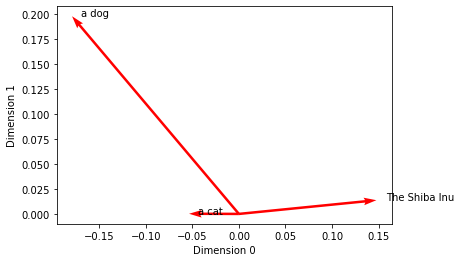

In [21]:
embeddings.plot(kind='arrow', color='red', x_axis=0, y_axis=1)

Each vector originates at the point $(0, 0)$. We can see that along dimensions $0$ and $1$, the directions and magnitudes (or: length) of the vectors differ considerably.

This results from averaging the vectors for each *Token* in the noun phrase.

To understand the effects of averaging vectors, let's retrieve embeddings for the indefinite article "a", the noun "dog" and the noun phrase "a dog" and plot the result along the same dimensions as above.

EmbSet

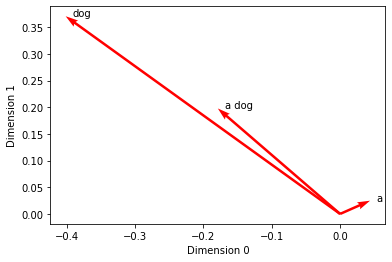

In [22]:
# Feed a list of string objects to the whatlies language object to get an EmbSet object
dog_embeddings = language_model[['a', 'dog', 'a dog']]

# Plot the EmbSet
dog_embeddings.plot(kind='arrow', color='red', x_axis=0, y_axis=1)

Along dimensions $0$ and $1$, the vector for "a dog" is positioned right in the middle between the vectors for "a" and "dog", because the vector for "a dog" is an average of the vectors for "a" and "dog".

We can easily verify this by getting the values for dimension $0$ from the 300-dimensional vectors for the tokens "a" and "dog".

In [23]:
# Get the embedding for 'a' from the EmbSet object 'dog_embeddings'; use the vector attribute
# and bracket to retrieve the value at index 0. Do the same for 'dog'. Assign under variables
# of the same name.
a = dog_embeddings['a'].vector[0]
dog = dog_embeddings['dog'].vector[0]

# Calculate average value and assign under 'dog_avg'
dog_avg = (a + dog) / 2

# Call the variable to examine the result
dog_avg

-0.1789810061454773

If you look at the plot above, you see that this value falls right where the arrow for "a dog" points along dimension $0$ on the horizontal axis.

We can verify this by getting the value for the first dimension in the vector for "a dog" from the *EmbSet* object.

In [24]:
dog_embeddings['a dog'].vector[0]

-0.178981

This raises the question whether averaging vectors for individual *Tokens* is a suitable strategy for representing larger linguistic units, because the direction and magnitude of a vector are supposed to capture the "meaning" of a word in relation to other words in the model's vocabulary (Boleda [2020](https://doi.org/10.1146/annurev-linguistics-011619-030303)).

To put it simply, averaging *Token* vectors to represent entire clauses and sentences may dilute the information encoded in the vectors, which also raises the question whether the indefinite article "a" and the noun "dog" are equally informative in the noun phrase "a dog".

One should also note that the vector representations are **static**. As we saw above, the vector representation for the indefinite article "a" remains the same regardless of the context in which this article occurs. In other words, the particular words in a model's vocabulary, such as "a", are always mapped to the same vector representation. The unique words in a model's vocabulary are often described as **lexical types**, whereas their instances in the data are known as **tokens**. 

We know, however, that the same word (or lexical type) may have different meanings, which may be inferred from the context in which they occur, but this cannot be captured by word embeddings which model lexical types, not tokens. In other words, although the vector representations are learned by making predictions about co-occurring words, information about the context in which the tokens occur are not encoded into the vector representation.

![](img/type_token.svg)

This limitation has been addressed by **contextual word embeddings**, which often use a neural network architecture named a [Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)). This architecture can encode information about the context in which a given token occurs into the vector representation.

Some models that build on this architecture include BERT (Devlin et al. [2019](https://www.aclweb.org/anthology/N19-1423/)) and GPT-3 (Brown et al. [2020](https://papers.nips.cc/paper/2020/hash/1457c0d6bfcb4967418bfb8ac142f64a-Abstract.html)). Both models are massive, featuring billions of parameters, and thus slow and expensive to train. 

## Contextual embeddings from Transformers

Given the time and resources needed to train a language model using the Transformer architecture from scratch, they are often trained once and then fine-tuned to specific tasks. In this context, fine-tuning refers to training only a part of the network, adapting what the model has already learned to more specific tasks.

These tasks include, for example, part-of-speech tagging, dependency parsing and the other tasks introduced in [Part II](../part_ii/03_basic_nlp.ipynb).

spaCy provides Transformer-based language models for English and several other languages, which outperform the "traditional" pipelines in terms of accuracy, but are slower to apply.

Let's start by loading a Transformer-based for the English language and assign this model under the variable `nlp_trf`.

In [25]:
# Load a Transformer-based language model; assing to variable 'nlp'
nlp_trf = spacy.load('en_core_web_trf')

On the surface, a *Language* object that contains a Transformer-based model looks and works just like any other language model in spaCy.

However, if we look under the hood of the *Language* object under `nlp_trf` using the `pipeline` attribute (see [Part II](../notebooks/part_ii/04_basic_nlp_continued.ipynb#Modifying-spaCy-pipelines)), we will see that the first component in the processing pipeline is a *Transformer*.

In [26]:
# Call the 'pipeline' attribute to examine the processing pipeline
nlp_trf.pipeline

[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x193e67360>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x14f82ce00>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x192370b80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1923783a0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x193ed4d00>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x193edba40>)]

The Transformer component generates vector representations that are then used for making predictions about the *Doc* objects and the *Tokens* contained within.

These include, among others, the standard linguistic annotations in the form of part-of-speech tags, syntactic dependencies, morphological features, named entities and lemmas.

Let's define an example sentence and feed it to the Transformer-based language model under `nlp_trf` and store the resulting *Doc* object under `example_doc`.

In [27]:
# Feed an example sentence to the model; store output under 'example_doc'
example_doc = nlp_trf("Helsinki is the capital of Finland.")

# Check the length of the Doc object
example_doc.__len__()

7

spaCy stores the vector representations generated by the Transformer into a *TransformerData* object, which can be accessed under the custom attribute `trf_data` of a *Doc* object.

Remember that spaCy stores custom attributes under a dummy attribute marked by an underscore `_`, which is reserved for user-defined attributes, as explained in [Part II](../notebooks/part_ii/04_basic_nlp_continued.ipynb#Adding-custom-attributes-to-spaCy-objects).

In [28]:
# Check the type of the 'trf_data' object using the type() function
type(example_doc._.trf_data)

spacy_transformers.data_classes.TransformerData

The output of from the Transformer is contained in the *[TransformerData](https://spacy.io/api/transformer#transformerdata)* object, which we will now explore in greater detail. 

To begin with, the `tensors` attribute of a *TransformerData* object contains a Python list with vector representations generated by the Transformer for individual *Tokens* and the entire *Doc* object.

The first item in the `tensors` list under index 0 contains the output for individual *Tokens*.

In [29]:
# Check the shape of the first item in the list
example_doc._.trf_data.tensors[0].shape

(1, 11, 768)

The second item under index 1 holds the output for the entire *Doc*.

In [30]:
# Check the shape of the first item in the list
example_doc._.trf_data.tensors[1].shape

(1, 768)

In both cases, the Transformer output is stored in a *tensor*, which is a mathematical term for describing a "bundle" of numerical objects (e.g. vectors) and their shape.

In the case of *Tokens*, we have a batch of 1 that consists of 11 vectors with 768 dimensions each.

We can access the first ten dimensions of each vector using the expression `[:10]`.

Note that we need the preceding `[0]` to enter the first "batch" of vectors in the tensor.

In [31]:
# Check the first ten dimensions of the tensor
example_doc._.trf_data.tensors[0][0][:10]

array([[ 0.0868378 , -0.773074  , -1.1122086 , ...,  0.44053352,
         0.3645861 , -0.48721913],
       [-1.3220202 , -0.58153194,  0.45662862, ..., -0.41105455,
        -1.5180315 , -0.87169576],
       [-1.1108418 , -0.5872122 ,  0.2594492 , ..., -0.46206388,
        -1.4726629 , -0.8277558 ],
       ...,
       [-0.30590385, -0.46042758, -0.08148614, ...,  2.4376943 ,
         0.6899609 , -1.0034345 ],
       [-0.02552482, -0.9502562 , -0.62682897, ...,  0.5177092 ,
         0.18616806,  0.41015238],
       [ 0.17655747, -0.5720693 , -1.3821048 , ...,  0.25179133,
         0.3483248 , -0.09476942]], dtype=float32)

Unlike word embeddings, which leverage information about co-occurring words to *learn* representations for tokens but discard this information afterwards, these embeddings also encode information about the context in which the word occurs!

But why is a spaCy *Doc* object with 7 *Token* objects represented by 11 vectors?

In the [previous section](../part_iii/03_embeddings.ipynb) we learned that vocabulary size is a frequent challenge in language modelling. Learning representations for every unique word would blow up the size of the model!

Because Transformers are trained on massive volumes of text, the model's vocabulary must be limited somehow.

To address this issue, Transformers use more complex tokenizers that identify frequently occurring character sequences in the data and learn embeddings for these sequences instead. These sequences, which are often referred as *subwords*, make up the vocabulary of the Transformer.

Let's examine how the example *Doc* under `example_doc` was tokenized for input to the Transformer.

This information is stored under the attribute `tokens` of the *TransformerData* object, which contains a dictionary. We can find the subwords under the key `input_texts`.

In [32]:
# Access the Transformer tokens under the key 'input_texts'
example_doc._.trf_data.tokens['input_texts']

[['<s>',
  'H',
  'els',
  'inki',
  'Ġis',
  'Ġthe',
  'Ġcapital',
  'Ġof',
  'ĠFinland',
  '.',
  '</s>']]

This provides the tokens provided to the Transformer *by its own tokenizer*. In other words, the Transformer does not use the same tokens as spaCy.

The input begins and terminates with tokens `<s>` and `</s>`, which mark the beginning and the end of the input sequence. The Transformer tokenizer also uses the character `Ġ` as a prefix to indicate that the token is preceded by a whitespace character.

For the most part, the Transformer tokens correspond roughly to those produced by spaCy, except for "Helsinki".

Because the token "Helsinki" is not present in the Transformer's vocabulary, the token is broken down into three subwords that exist in the vocabulary: `H`, `els` and `inki`. Their vectors are used to construct a representation for the token "Helsinki".

![](img/alignment.svg)

To map these vectors to *Tokens* in the spaCy *Doc* object, we must retrieve alignment information from the `align` attribute of the *TransformerData* object.

The `align` attribute can be indexed using the indices of *Token* objects in the *Doc* object. 

To exemplify, we can retrieve the first *Token* "Helsinki" in the *Doc* object `doc` using the expression `example_doc[0]`.

We then use the index of this *Token* in the *Doc* object to retrieve alignment data, which is stored under the `align` attribute.

More specifically, we need the information stored under the attribute `data`.

In [33]:
# Get the first spaCy Token, "Helsinki", and its alignment data
example_doc[0], example_doc._.trf_data.align[0].data

(Helsinki,
 array([[1],
        [2],
        [3]], dtype=int32))

The `data` attribute contains a NumPy array that identifies which vectors in the list stored under the `tensors` attribute of a *TransformerData* object contain representations for this *Token*.

In this case, vectors at indices 1, 2 and 3 in the batch of 11 vectors contain the representation for "Helsinki".

To use the contextual embeddings from the Transformer efficiently, we can define a component that retrieves contextual word embeddings for *Docs*, *Spans* and *Tokens* and add this component to the spaCy pipeline.

This can be achieved by creating a new Python *Class* – a user-defined object with attributes and methods.

Because the new *Class* will become a component of the spaCy pipeline, we must first import the *Language* object and let spaCy know that we are now defining a new pipeline component.

In [34]:
# Import the Language object under the 'language' module in spaCy,
# and NumPy for calculating cosine similarity.
from spacy.language import Language
import numpy as np

# We use the @ character to register the following Class definition
# with spaCy under the name 'tensor2attr'.
@Language.factory('tensor2attr')

# We begin by declaring the class name: Tensor2Attr. The name is 
# declared using 'class', followed by the name and a colon.
class Tensor2Attr:
    
    # We continue by defining the first method of the class, 
    # __init__(), which is called when this class is used for 
    # creating a Python object. Custom components in spaCy 
    # require passing two variables to the __init__() method:
    # 'name' and 'nlp'. The variable 'self' refers to any
    # object created using this class!
    def __init__(self, name, nlp):
        
        # We do not really do anything with this class, so we
        # simply move on using 'pass' when the object is created.
        pass

    # The __call__() method is called whenever some other object
    # is passed to an object representing this class. Since we know
    # that the class is a part of the spaCy pipeline, we already know
    # that it will receive Doc objects from the preceding layers.
    # We use the variable 'doc' to refer to any object received.
    def __call__(self, doc):
        
        # When an object is received, the class will instantly pass
        # the object forward to the 'add_attributes' method. The
        # reference to self informs Python that the method belongs
        # to this class.
        self.add_attributes(doc)
        
        # After the 'add_attributes' method finishes, the __call__
        # method returns the object.
        return doc
    
    # Next, we define the 'add_attributes' method that will modify
    # the incoming Doc object by calling a series of methods.
    def add_attributes(self, doc):
        
        # spaCy Doc objects have an attribute named 'user_hooks',
        # which allows customising the default attributes of a 
        # Doc object, such as 'vector'. We use the 'user_hooks'
        # attribute to replace the attribute 'vector' with the 
        # Transformer output, which is retrieved using the 
        # 'doc_tensor' method defined below.
        doc.user_hooks['vector'] = self.doc_tensor
        
        # We then perform the same for both Spans and Tokens that
        # are contained within the Doc object.
        doc.user_span_hooks['vector'] = self.span_tensor
        doc.user_token_hooks['vector'] = self.token_tensor
        
        # We also replace the 'similarity' method, because the 
        # default 'similarity' method looks at the default 'vector'
        # attribute, which is empty! We must first replace the
        # vectors using the 'user_hooks' attribute.
        doc.user_hooks['similarity'] = self.get_similarity
        doc.user_span_hooks['similarity'] = self.get_similarity
        doc.user_token_hooks['similarity'] = self.get_similarity
    
    # Define a method that takes a Doc object as input and returns 
    # Transformer output for the entire Doc.
    def doc_tensor(self, doc):
        
        # Return Transformer output for the entire Doc. As noted
        # above, this is the last item under the attribute 'tensor'.
        # Average the output along axis 0 to handle batched outputs.
        return doc._.trf_data.tensors[-1].mean(axis=0)
    
    # Define a method that takes a Span as input and returns the Transformer 
    # output.
    def span_tensor(self, span):
        
        # Get alignment information for Span. This is achieved by using
        # the 'doc' attribute of Span that refers to the Doc that contains
        # this Span. We then use the 'start' and 'end' attributes of a Span
        # to retrieve the alignment information. Finally, we flatten the
        # resulting array to use it for indexing.
        tensor_ix = span.doc._.trf_data.align[span.start: span.end].data.flatten()
        
        # Fetch Transformer output shape from the final dimension of the output.
        # We do this here to maintain compatibility with different Transformers,
        # which may output tensors of different shape.
        out_dim = span.doc._.trf_data.tensors[0].shape[-1]
        
        # Get Token tensors under tensors[0]. Reshape batched outputs so that
        # each "row" in the matrix corresponds to a single token. This is needed
        # for matching alignment information under 'tensor_ix' to the Transformer
        # output.
        tensor = span.doc._.trf_data.tensors[0].reshape(-1, out_dim)[tensor_ix]
        
        # Average vectors along axis 0 ("columns"). This yields a 768-dimensional
        # vector for each spaCy Span.
        return tensor.mean(axis=0)
    
    # Define a function that takes a Token as input and returns the Transformer
    # output.
    def token_tensor(self, token):
        
        # Get alignment information for Token; flatten array for indexing.
        # Again, we use the 'doc' attribute of a Token to get the parent Doc,
        # which contains the Transformer output.
        tensor_ix = token.doc._.trf_data.align[token.i].data.flatten()
        
        # Fetch Transformer output shape from the final dimension of the output.
        # We do this here to maintain compatibility with different Transformers,
        # which may output tensors of different shape.
        out_dim = token.doc._.trf_data.tensors[0].shape[-1]
        
        # Get Token tensors under tensors[0]. Reshape batched outputs so that
        # each "row" in the matrix corresponds to a single token. This is needed
        # for matching alignment information under 'tensor_ix' to the Transformer
        # output.
        tensor = token.doc._.trf_data.tensors[0].reshape(-1, out_dim)[tensor_ix]

        # Average vectors along axis 0 (columns). This yields a 768-dimensional
        # vector for each spaCy Token.
        return tensor.mean(axis=0)
    
    # Define a function for calculating cosine similarity between vectors
    def get_similarity(self, doc1, doc2):
        
        # Calculate and return cosine similarity
        return np.dot(doc1.vector, doc2.vector) / (doc1.vector_norm * doc2.vector_norm)

Although the previous cell is relatively long, note that the comments explaining the actions taken took up most of the space!

With the *Class* `Tensor2Attr` defined, we can now add it to the pipeline by referring to the name we registered with spaCy using `@Language.factory()`, that is, `tensor2attr`, as instructed in [Part II](../part_ii/04_basic_nlp_continued.ipynb#Simplifying-output-for-noun-phrases-and-named-entities). 

In [35]:
# Add the component named 'tensor2attr', which we registered using the
# @Language decorator and its 'factory' method to the pipeline.
nlp_trf.add_pipe('tensor2attr')

# Call the 'pipeline' attribute to examine the pipeline
nlp_trf.pipeline

[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x193e67360>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x14f82ce00>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x192370b80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1923783a0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x193ed4d00>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x193edba40>),
 ('tensor2attr', <__main__.Tensor2Attr at 0x196c2e6a0>)]

The output shows that the component named `tensor2attr` was added to the spaCy pipeline.

This component stores the Transformer-based contextual embeddings for *Docs*, *Spans* and *Tokens* under the `vector` attribute.

Let's explore contextual embeddings by defining two *Doc* objects and feeding them to the Transformer-based language model under `nlp_trf`.

In [36]:
# Define two example sentences and process them using the Transformer-based
# language model under 'nlp_trf'.
doc_city_trf = nlp_trf("Helsinki is the capital of Finland.")
doc_money_trf = nlp_trf("The company is close to bankruptcy because its capital is gone.")

The noun "capital" has two different meanings in these sentences: in `doc_city_trf`, "capital" refers to a city, whereas in `doc_money_trf` the word refers to money.

The Transformer should encode this difference into the resulting vector based on the context in which the word occurs.

Let's fetch the *Token* corresponding to "capital" in each example and retrieve their vector representations under the `vector` attribute.

In [37]:
# Retrieve vectors for the two Tokens corresponding to "capital";
# assign to variables 'city_trf' and 'money_trf'.
city_trf = doc_city_trf[3]
money_trf = doc_money_trf[8]

# Compare the similarity of the two meanings of 'capital'
city_trf.similarity(money_trf)

0.52077717

As you can see, the vectors for the word "capital" are only somewhat similar, because the Transformer also encodes information about their context of occurrence into the vectors, which has allowed it to learn that the same linguistic form may have different meanings in different contexts.

This stands in stark contrast to the *static* word embeddings available in the large language model for English stored under the variable `nlp_lg`.

In [38]:
# Define two example sentences and process them using the large language model
# under 'nlp_lg'
doc_city_lg = nlp_lg("Helsinki is the capital of Finland.")
doc_money_lg = nlp_lg("The company is close to bankruptcy because its capital is gone.")

# Retrieve vectors for the two Tokens corresponding to "capital";
# assign to variables 'city_lg' and 'money_lg'.
city_lg = doc_city_lg[3]
money_lg = doc_money_lg[8]

# Compare the similarity of the two meanings of 'capital'
city_lg.similarity(money_lg)

1.0

As you can see, the vectors for the word "capital" are identical, because the word embeddings do not encode information about the context in which the word occurs. 

### Quick exercise

Define two words with similar forms but different meanings, feed them to the Transformer-based language model under `nlp_trf` and compare their cosine similarity.

In [39]:
# Write your code below this line and press Shift and Enter to run the code


This section should have given you a basic understanding of word embeddings and their use in spaCy, and introduced you to the difference between word embeddings and contextual word embeddings.

In the next [section](../notebooks/part_iii/05_text_linguistics.ipynb), we proceed to examine the processing of discourse-level annotations.